In [312]:
# Passos do Projeto:

# 1 - Definição do Problema
# 2 - Escolha do conjunto de dados simples
# 3 - Teste de modelagem e algoritmos
# 4 - Escolha do conjunto de dados final
# 5 - Teste de modelagem e algoritmos
# 6 - Resultados

# A fazer:
    
# 7 - Otimizacao da ferramenta
# 8 - Resultados obtidos
# 9 - Conclusão

**Librarys**

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pandas_profiling import ProfileReport
from typing import List
from dateutil.relativedelta import relativedelta

from fbprophet import Prophet

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import shap

# print the JS visualization code to the notebook
shap.initjs()

**Functions**

In [314]:
def shift_column(df, column: List[str], lags: List[int]):
    # Realiza o shift (lag) de uma coluna passada no numero de lags
    df = df.sort_index()
    for column in cols_2lag:
        for lag in lags:
            df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        return df

In [315]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Calcula o MAPE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**1- Business Understand**

Referencias:

1- EAD - https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

CRISP-DM esolhido no lugar do SEMMA e do KDD

Problema:

- Entender o comportamento de consumo de energia Elétrica e as relações intrinsecas nos dados que permitem a projeção
  do consumo de carga para horizontes futuros, a partir do entendimento dos padrões escondidos na modelagem

Dataset:

- Dataset de consumo horiario de energia

**Data Understand**

O entendimento dos dados esta baseado nos seguintes passos:

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2. **Univariable study**. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.
4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers and categorical variables.
5. **Test assumptions**. We'll check if our data meets the assumptions required by most multivariate techniques.

Por ser um problema de série temporal temos como **Features**:

- **Comportamento Sazonal** (influencia de grupo ou de tempo) + **Compartamento Externo**

In [316]:
# Leitura dos dados

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [317]:
# COLUNAS

# - ID - Id unico por registro
# - DATETIME - datas horarias
# - TEMPERATURE - temperatura
# - VAR1 - variavel aleatoria
# - PRESSURE - pressao
# - WINDSPEED - velocidade do vento
# - VAR2 - variavel aleatoria
# - ELETRICITY_CONSUMPTION - eletricidade consumida (TARGET)

**Estudo Univariado**

In [318]:
train.electricity_consumption.describe()

count    26496.000000
mean       298.359601
std        108.020555
min        174.000000
25%        219.000000
50%        267.000000
75%        342.000000
max       1386.000000
Name: electricity_consumption, dtype: float64

1.904813922542204
5.723568296844449


<Figure size 864x576 with 0 Axes>

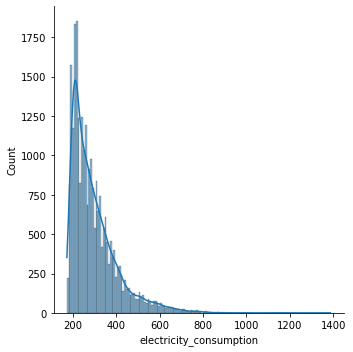

In [319]:
# Skew - Assimetria - https://www.grancursospresencial.com.br/novo/upload/A419092005194957.pdf

# As medidas de assimetria indicam o grau de assimetria de uma distribuição de freqüências
# unimodal em relação a uma linha vertical que passa por seu ponto mais elevado.
# Graficamente, uma distribuição simétrica tem associada a si uma curva de freqüências
# unimodal apresentando duas "caudas" simétricas em relação a uma linha vertical que passa por seu
# ponto mais alto (eixo de simetria).

# Graficamente, uma distribuição simétrica tem associada a si uma curva de freqüências
# unimodal apresentando duas "caudas" simétricas em relação a uma linha vertical que passa por seu
# ponto mais alto (eixo de simetria).

# Kurtosis - Curtose - Achatamento

# Denomina - se curtose ao grau de “achatamento” de uma distribuição de freqüências,
# geralmente unimodal, medido em relação ao de uma distribuição normal (de Gauss) que é tomada
# como padrão.

print(train.electricity_consumption.skew()) # Skew > 0, right asymmetry - Skew < 0, left asymmetry 

print(train.electricity_consumption.kurt()) # Kurtosis obtained using Fisher’s definition of kurtosis (kurtosis of normal == 0.0). > 0 Mais achatada

plt.figure(figsize=(12,8))

sns.displot(train, x='electricity_consumption', kde=True)

<AxesSubplot:xlabel='electricity_consumption'>

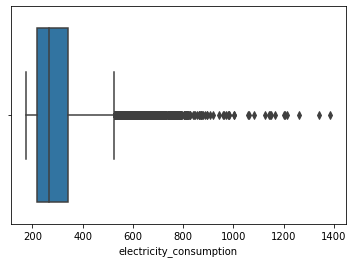

In [320]:
sns.boxplot(data=train, x='electricity_consumption')

In [321]:
train["datetime"] = pd.to_datetime(train["datetime"])

train = train.sort_values(by="datetime")

px.line(train, x="datetime", y="electricity_consumption")

Outliers

Vamos realizar o plot apenas dos outliers para entender quando eles ocorrem. Neste caso utilizamos uma abordagem de Intervalos Interquartil

In [322]:
Q3 = np.quantile(train["electricity_consumption"], 0.75)
Q1 = np.quantile(train["electricity_consumption"], 0.25)
IQR = Q3 - Q1

outliers_df = train[train["electricity_consumption"] > Q3 + 1.5* IQR].copy()
outliers_df["month"] = outliers_df["datetime"].dt.month
outliers_df["month_name"] = outliers_df["datetime"].dt.month_name()
outliers_monthly_df = outliers_df.groupby(['month', 'month_name'])["ID"].count().reset_index().rename(
    columns={"ID": "count_id"}).sort_values(by="month")

fig = px.bar(outliers_monthly_df, x="month_name", y="count_id", title="Quantidade de Registros com Alto Consumo (MW) por Mes", text="count_id")

fig.update_layout(xaxis_title="", yaxis_title="Contagem Registros com Alto Consumo")

fig.show()

Prophet Introduction:

https://www.kaggle.com/janiobachmann/s-p-500-time-series-forecasting-with-prophet?scriptVersionId=9048402

Prophet is Facebook's library for time series forecasting. In my opinion, Prophet works best with datasets that are higely influenced by seasonality (electricity bills, restaurant visitors etc.) However, I wanted to show the simplicity of using Prophet for simple forecasting which is the main aim of this kernel.

In [323]:
prophet = Prophet()

In [324]:
train_ph = train.sort_values(by="datetime")

train_ph, y = train_test_split(train_ph, test_size=0.2, shuffle=False)

In [325]:
ph_df = train_ph[['datetime', 'electricity_consumption']].rename(columns={"datetime": "ds", "electricity_consumption": "y"}).copy()

In [326]:
ph_df

ds      y
0     2013-07-01 00:00:00  216.0
1     2013-07-01 01:00:00  210.0
2     2013-07-01 02:00:00  225.0
3     2013-07-01 03:00:00  216.0
4     2013-07-01 04:00:00  222.0
...                   ...    ...
21191 2016-09-09 23:00:00  264.0
21192 2016-09-10 00:00:00  231.0
21193 2016-09-10 01:00:00  222.0
21194 2016-09-10 02:00:00  225.0
21195 2016-09-10 03:00:00  201.0

[21196 rows x 2 columns]

In [327]:
prophet.fit(ph_df)

In [328]:
future_consumption = prophet.make_future_dataframe(periods=365)

In [205]:
forecast = prophet.predict(future_consumption)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

ds        yhat  yhat_lower  yhat_upper
0     2013-07-01 00:00:00  218.843735   86.257090  342.743166
1     2013-07-01 01:00:00  219.042717   81.727713  348.510708
2     2013-07-01 02:00:00  218.150852   84.054711  348.967821
3     2013-07-01 03:00:00  215.562802   90.831711  354.433654
4     2013-07-01 04:00:00  211.610950   73.917968  346.153768
...                   ...         ...         ...         ...
21556 2017-09-06 03:00:00  361.836296   46.920235  662.980651
21557 2017-09-07 03:00:00  363.096390   46.011376  698.914011
21558 2017-09-08 03:00:00  352.915388   29.461038  671.010880
21559 2017-09-09 03:00:00  351.296018   25.207910  672.921806
21560 2017-09-10 03:00:00  353.354555   19.660194  689.802302

[21561 rows x 4 columns]

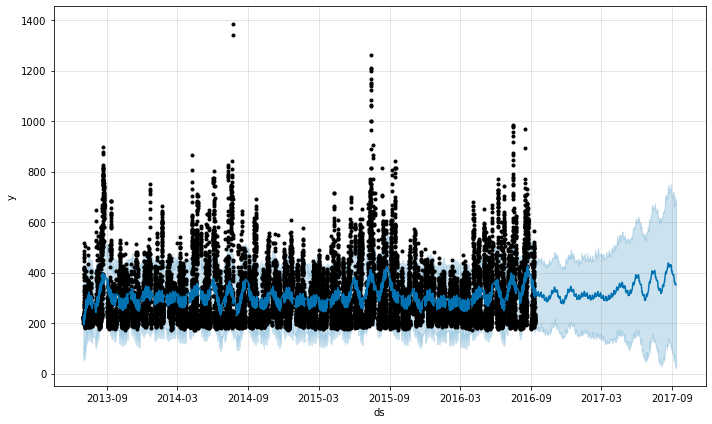

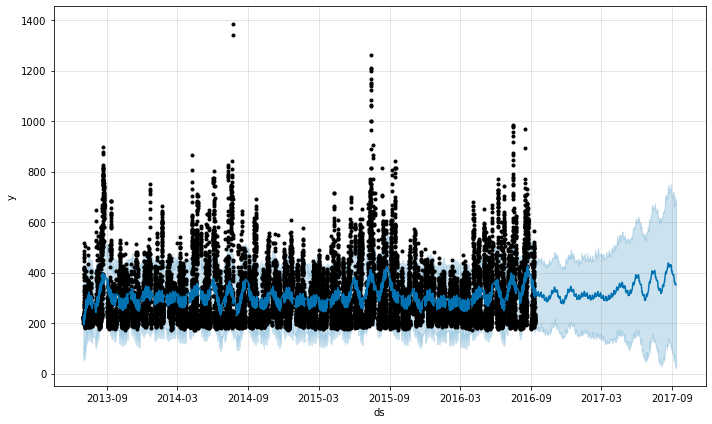

In [206]:
prophet.plot(forecast)

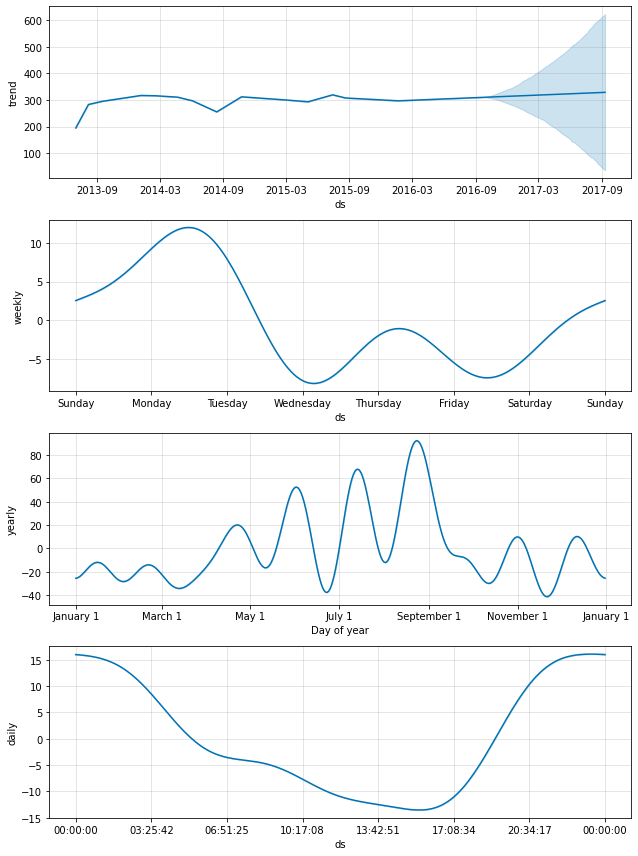

In [207]:
fig = prophet.plot_components(forecast)

Podemos ver que a tendencia da serie eh de estabilidade desde de 2015. Dessa forma não é esperamos que tenha alta tendência esse ano

Semanalmente, vemos que **sabado, domingo, segunda e terca** temos uma demanda maior que nos outros dias. Chamando atencao para o pico entre segunda e terca. Uma variavel de dia da semana pode nos ajudar neste caso

Mensalmente, vemos que os dados tem forte sazonalidade, principalmente, como já visto, na metade do ano. Parece que temos a tendência de nos meses de junho, julho e agosto termos um alto consumo de energia

Já diariamente, vemos que no final do dia e no comeco a demanda geralmente eh mais alta do que no decorrer do dia

In [208]:
predict_df = y.merge(forecast[["ds", "yhat"]], left_on="datetime", right_on="ds")

In [209]:
mape = mean_absolute_percentage_error(predict_df["electricity_consumption"], predict_df["yhat"])

In [210]:
mape

28.454923268304235

Somente com a variavel de consumo na previsao, e utilizando a sazonalidade, o erro fica alto

**Estudo multivariado**

Relacão com variáveis numéricas

In [211]:
px.scatter(train, x='electricity_consumption', y='temperature')

Parece que temos uma leve correlacao negativa entre a temperatura e o consumo de energia. E dados com consumo muito alto sao em temperaturas muito baixas, o que faz sentido por consumo de aquecedor e outros

In [212]:
px.scatter(train, x='electricity_consumption', y='pressure')

Parece que o consumo nao tem muita correlacao com os dados de pressão.

In [213]:
px.scatter(train, x='electricity_consumption', y='windspeed')

In [214]:
px.scatter(train, x='electricity_consumption', y='var1')

Podemos notar que o consumo de energia tem uma leve correlacao com a var1. Em valores mais altos de var 1 tendemos a ter maior consumo de energia em algumns casos

Parece que a velocidade do vento tem uma alta correlacao com o consumo de energia. Quanto maior a velocidade do vento, menor é o consumo.

Isso pode estar ligado a outra matriz energética, eólica, entrando em funcionamento e assim diminuindo o consumo. Nao tivemos informacoes de quais matrizes energeticas sao esse dataframe.

<AxesSubplot:>

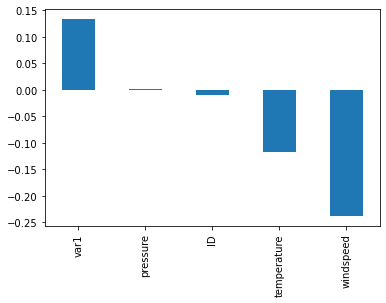

In [215]:
# Correlacoes

train.corr()["electricity_consumption"].sort_values(ascending=False).iloc[1:].plot.bar()

# TODO: check p-value - estatisticamente significante

# Velocidade do vento o consumo de energia tem relacao Negativa

# Temperatura e consumo de energia tem relacao Negativa

# Variavel 1 e consumo de energia tem relacao Positiva

# Hipoteses

# Uma explicacao para a correlacao negativa com a velocidade do vento alta, eh que a matriz energetica eolica pode produzir
# mais energia e com isso tem uma queda de demanda do dataset

Relacão com variáveis Categoricas

In [216]:
train.dtypes[train.dtypes == 'object']

var2    object
dtype: object

<AxesSubplot:xlabel='var2', ylabel='electricity_consumption'>

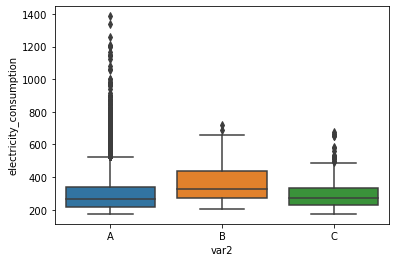

In [217]:
sns.boxplot(data=train, x='var2', y='electricity_consumption')

Parece que a demanda é um pouco maior quando é classificada no grupo B. Porém os grupos C e A sao similares

**Data cleaning**

Lista checks:

- Tipo de Dados
- Valores Nulos Faltantes
- Repetidos
- Valores Zero/ Discrepantes

In [218]:
# REPORT

# ProfileReport(train)

# Insights:

# A coluna data tem alta cardianalidade (todos os valores diferentes, o que já era de se esperar)
# datetime and id tem apenas valores unicos
# temperature tem 522 (2.0%) zeros
# var1 tem 424 (1.6%) zeros

In [330]:
# Converting to datetime

train["datetime"] = pd.to_datetime(train.datetime)
test["datetime"] = pd.to_datetime(test.datetime)

In [331]:
# Index

train.set_index("datetime", inplace=True)
test.set_index("datetime", inplace=True)

In [332]:
# Check dates completeness

print(train.index.freq)

date_range = pd.date_range(train.index.min(), train.index.max(), freq="H")

print(date_range.difference(train.index))
print(date_range.difference(train.index).shape)

None
DatetimeIndex(['2013-07-24 00:00:00', '2013-07-24 01:00:00',
               '2013-07-24 02:00:00', '2013-07-24 03:00:00',
               '2013-07-24 04:00:00', '2013-07-24 05:00:00',
               '2013-07-24 06:00:00', '2013-07-24 07:00:00',
               '2013-07-24 08:00:00', '2013-07-24 09:00:00',
               ...
               '2017-05-31 14:00:00', '2017-05-31 15:00:00',
               '2017-05-31 16:00:00', '2017-05-31 17:00:00',
               '2017-05-31 18:00:00', '2017-05-31 19:00:00',
               '2017-05-31 20:00:00', '2017-05-31 21:00:00',
               '2017-05-31 22:00:00', '2017-05-31 23:00:00'],
              dtype='datetime64[ns]', length=8400, freq=None)
(8400,)


Plots de Dispersao e Tendencia

In [333]:
# for c in train.select_dtypes(include=np.number).columns: 
    
#     fig = px.histogram(train, c)
#     fig.show()

In [334]:
# Criação das Features Temporais

# Features Sazonais:

# Hora - hour
# Dia da semana, dia do mes, dia do ano - isocalenda()["day"], day, dayofwear
# Semana do Ano - isocalendar()["week"]
# Mes - month
# Juncao de Mes, sazonalidade 4 meses - quarter
# Ano - year

train["hour"] = train.index.hour
train["dow"]= train.index.isocalendar()['day'].astype("int64")
train["dom"] = train.index.day
# train["doy"] = train.index.dayofyear
train["woy"] = train.index.isocalendar()['week'].astype("int64")
train["month"] = train.index.month
train["quarter"] = train.index.quarter
train["year"] = train.index.isocalendar()['year'].astype("int64")

train["date"] = train.index

test["hour"] = test.index.hour
test["dow"]= test.index.isocalendar()['day'].astype("int64")
test["dom"] = test.index.day
# test["doy"] = test.index.dayofyear
test["woy"] = test.index.isocalendar()['week'].astype("int64")
test["month"] = test.index.month
test["quarter"] = test.index.quarter
test["year"] = test.index.isocalendar()['year'].astype("int64")

test["date"] = test.index



In [335]:
# fig = px.line(train, x="date", y="electricity_consumption")

# fig.update_layout(title="Energy Consumption (KW) vs. Hour", xaxis_title="Hour", yaxis_title="Energy Consumption")

In [336]:
# _ = train.groupby(["hour", "dow"], as_index=False)["electricity_consumption"].agg('median')

# px.line(_, x="hour", y="electricity_consumption", color="dow")

**4- Modeling**

In [337]:
def grid_search(model, X_train, y_train):
    # grid search for hiperparamns

    # depth (profundidade da arvore) - default - 6
    # learning_rate (taxa de aprendizagem - Used for reducing the gradient step.) - default - 
    # 12_leaf_reg - default -

    grid = {'learning_rate': [0.03, 0.1],
            'depth': [4, 6, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'iterations': 500} 

    grid_search_result = model.grid_search(grid, 
                                           X=X_train, 
                                           y=y_train, 
                                           plot=True)
    print(grid_search_result['params'])

Grid Search in time series:
https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

In [366]:
def grid_search_cv(model, X_train, y_train, grid, cv=2, scoring='neg_mean_absolute_percentage_error'):
    
    clf = GridSearchCV(model, grid, cv=cv, return_train_score=False, scoring=scoring)
    
    clf.fit(X_train, y_train)
        
    return clf.best_score_, clf.best_params_

In [339]:
def plot_result(y_valid, predict_val, name_model):    
    predict_df = pd.DataFrame(y_valid)
    predict_df["predict"] = predict_val
    predict_df["datetime"] = predict_df.index

    predict_df.columns = ["Demanda Real", "Demanda Projetada", "Date"]

    fig = px.line(
        predict_df,
        x='Date',
        y=["Demanda Real", "Demanda Projetada"],
        title=f"Demanda Horária de Energia (MW) [{predict_df.Date.dt.year.min()} - {predict_df.Date.dt.year.max()}] - Modelagem {name_model}"
    )

    fig.update_layout(yaxis_title="Demanda Elétrica (MW)", xaxis_title="Data e Hora (yyyy/mm/dd hh:MM)")
    fig.update_traces(line=dict(width=1))
    
    fig.write_html("file.html")
    
    fig.show()

In [281]:
def plot_shap(model, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)

1- LightGBM

Shap -documentation:https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [356]:
train_df = train.copy()

MAPE: 23.81
C extension was not built during install!


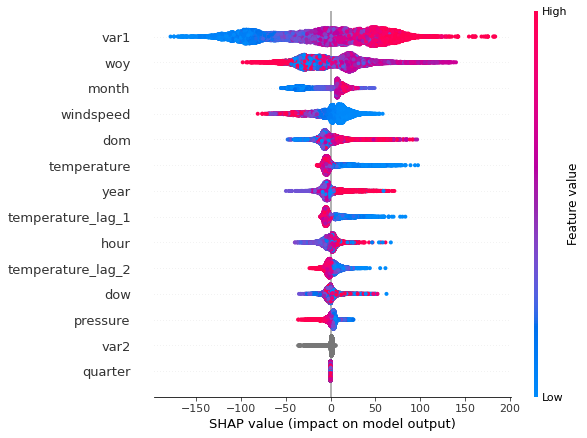

In [377]:
APPLY_GRID = False
cols_2lag = ["temperature", "var1", "windspeed"]
n_lags = [1, 2]
label = "electricity_consumption"
forbiden = ["ID", "date"]
cat_cols = [c for c in train.dtypes[train.dtypes.isin(['object', 'categorical'])].index]
params = {'categorical_feature':cat_cols, 'learning_rate': 0.1, 'max_depth': 10}

# Lag Features
train_df = shift_column(train_df, cols_2lag, lags=n_lags)


# LightGBM can handdle with categorical features, not object.
# A categorical variable takes on a limited, and usually fixed, number of possible values.
for c in cat_cols: 
    train_df[c] = train_df[c].astype('category')


# Train Test Split

y = train_df[label]
X = train_df.drop(columns=[label] + forbiden)
X_train, X_valid, y_train, y_valid = train_test_split(
                                            X,
                                            y, 
                                            test_size=0.20, 
                                            shuffle=False,
                                            random_state=False
)

tscv = TimeSeriesSplit(n_splits=10)

if APPLY_GRID:
    grid = {
        'learning_rate': [0.03, 0.1],
        'max_depth': [4, 6, 10],
    }
    model = LGBMRegressor()
    best_score, best_params = grid_search_cv(model, X_train, y_train,grid, tscv)


else:

    # Baseline Model
    model = LGBMRegressor(**params)
    
    # Fit

    model.fit(
        X_train,
        y_train,)


    # Predict
    predict = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, predict)
    print(f"MAPE: {round(mape, 2)}")

    plot_shap(model, X_train)

In [391]:
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, 
                            scoring='neg_mean_absolute_percentage_error', n_jobs=1, fit_params={'categorical_features': cat_cols}) # hangs with n_jobs > 1, and locally t

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
TypeError: fit() got an unexpected keyword argument 'categorical_features'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/anaconda3/envs/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
TypeError: fit() got an unexpected keyword argument 'categorical_features'

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felipe/anaconda3/

In [83]:
plot_result(y_valid, predict, name_model="LGBM")

2- Catboost

In [350]:
train_df = train.copy()

In [351]:
APPLY_GRID = False
cols_2lag = ["temperature", "var1", "windspeed"]
lags = [1, 2, 3, 4]
label = "electricity_consumption"
forbiden = ["ID", "date"]
cat_cols = [c for c in train.dtypes[train.dtypes.isin(['object', 'category'])].index]

params = {
    'cat_features': cat_cols,
    'logging_level': 'Silent',
    'depth': 10,
    'l2_leaf_reg': 5,
    'learning_rate': 0.1
}


# Baseline Model

model = CatBoostRegressor(**params)

# Lag Features

train_df = shift_column(train, cols_2lag, lags=lags)


# Train Test Split

y = train_df[label]
X = train_df.drop(columns=[label] + forbiden)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=False)


if APPLY_GRID:
    grid_search(model, X_train, y_train)
    
else:
    # Fit
    
    model.fit(X_train, y_train)
    
    # Predict
    predict_val = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, predict_val)
    print(f"MAPE: {round(mape, 2)}")

    # Shap
    plot_shap(model, X_train)

MAPE: 21.54


KeyboardInterrupt: 

3- CNN

documentation: https://www.tensorflow.org/?hl=pt-br

tutorial: https://www.tensorflow.org/tutorials?hl=pt-br

In [ ]:
train_df = train.copy()

In [ ]:
y = train_df["electricity_consumption"]

X = train_df.drop(columns=["electricity_consumption", "ID", "date", "var2", "temperature_lag_1", "var1_lag_1", "windspeed_lag_1"])

In [ ]:
X.info()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=False)

In [ ]:
X_train = X_train.values
X_valid = X_valid.values

y_train = y_train.values
y_valid = y_valid.values

In [ ]:
# Data Scalling

In [ ]:
# Standard Scaling

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)

In [ ]:
# Normalizing the target variables
y_train_scaller = (y_train - min(y_train))/ (max(y_train) - min(y_train))

In [ ]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train, y_train_scaller, batch_size = 10, epochs = 100)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_valid)
y_pred = (y_pred * (max(y_train) - min(y_train))) + min(y_train)

predictions = [int(elem) for elem in y_pred]

In [ ]:
# MAPE

mape = mean_absolute_percentage_error(y_valid, predictions)
print(round(mape,2))

In [ ]:
predict_df = pd.DataFrame(y_valid)

predict_df["predict"] = predictions

predict_df["datetime"] = predict_df.index

In [ ]:
predict_df = pd.DataFrame(y_valid)
predict_df["predict"] = predictions
predict_df["datetime"] = predict_df.index

predict_df.columns = ["Demanda Real", "Demanda Projetada", "Date"]

fig = px.line(
    predict_df,
    x='Date',
    y=["Demanda Real", "Demanda Projetada"],
    title=f"Demanda Horária de Energia (MW) [{predict_df.Date.dt.year.min()} - {predict_df.Date.dt.year.max()}] - ANN"
)

fig.update_layout(yaxis_title="Demanda Elétrica (MW)", xaxis_title="Data e Hora (yyyy/mm/dd hh:MM)")
fig.update_traces(line=dict(width=1))